In [1]:
# safetylayer was scheduled every 5 sec
# OptLayerPolicy AND OptLayer both logged "Activated", i.e. double counted when objective value is > 1e6
# 2024-05-23 15:00:00 reactive power in safety layer --> starting from 2024-05-25 15:00:00 stable version (filter out false positives)

#filtered_df_5s.dropna()

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from smart_village_interface.intervillage.inputs.reader import VillageHouseReader


def safety_layer_results(house_num, ems):

    log_folder = 'results/experiment_1/'

    filter_query = {
        "house_num": [house_num],
        "asset": ["safetylayer", "grid1", "bat1", "charger1"],
        "_field": ["Activated", "ObjValue", "SafeAction_bess", "SafeAction_ev", "UnsafeAction_bess", "UnsafeAction_ev", "power_W", "soc"],
        "controller": [],
    }

    influx_reader = VillageHouseReader()
    influx_reader.interpolate = False

    # Function to query data in chunks
    def query_in_chunks(start_time, end_time, chunk_size, filter_query):
        current_start = start_time
        all_data = []

        while current_start < end_time:
            current_end = min(current_start + chunk_size, end_time)
            try:
                house_info = influx_reader.read_houses(current_start.isoformat()+'Z', current_end.isoformat()+'Z', "5s", filter_query)
                all_data.append(house_info)
            except Exception as e:
                print(f"Error querying data from {current_start} to {current_end}: {e}")
            current_start = current_end

        return all_data

    # Define time range and chunk size
    start_time = datetime.fromisoformat('2024-04-10T15:00:00')
    end_time = datetime.fromisoformat('2024-06-19T15:00:00')
    chunk_size = timedelta(days=7)  # Adjust this chunk size as necessary

    # Query data in chunks
    all_data = query_in_chunks(start_time, end_time, chunk_size, filter_query)

    # Initialize empty lists to store flattened data
    time_list = []
    data_lists = {key: [] for key in ['power_W_bat1', 'soc_bat1', 'power_W_charger1', 'soc_charger1', 'power_W_grid1',
                                    'Activated', 'ObjValue', 'SafeAction_bess', 'SafeAction_ev', 'UnsafeAction_bess', 'UnsafeAction_ev']}

    # Flatten the nested structure
    for entry in all_data:
        time = pd.to_datetime(entry['time'])  # Convert time to datetime
        house_data = entry[f'house_{house_num}']
        
        time_list.extend(time)
        
        # Extract data for bat1
        data_lists['power_W_bat1'].extend(house_data.get('bat1', {}).get('power_W', [np.nan] * len(time)))
        data_lists['soc_bat1'].extend(house_data.get('bat1', {}).get('soc', [np.nan] * len(time)))
        
        # Extract data for charger1
        data_lists['power_W_charger1'].extend(house_data.get('charger1', {}).get('power_W', [np.nan] * len(time)))
        data_lists['soc_charger1'].extend(house_data.get('charger1', {}).get('soc', [np.nan] * len(time)))
        
        # Extract data for grid1
        data_lists['power_W_grid1'].extend(house_data.get('grid1', {}).get('power_W', [np.nan] * len(time)))
        
        # Append safety layer data (assuming it's uniform across time)
        data_lists['Activated'].extend(house_data['safetylayer'].get('Activated', [np.nan] * len(time)))
        data_lists['ObjValue'].extend(house_data['safetylayer'].get('ObjValue', [np.nan] * len(time)))
        data_lists['SafeAction_bess'].extend(house_data['safetylayer'].get('SafeAction_bess', [np.nan] * len(time)))
        data_lists['SafeAction_ev'].extend(house_data['safetylayer'].get('SafeAction_ev', [np.nan] * len(time)))
        data_lists['UnsafeAction_bess'].extend(house_data['safetylayer'].get('UnsafeAction_bess', [np.nan] * len(time)))
        data_lists['UnsafeAction_ev'].extend(house_data['safetylayer'].get('UnsafeAction_ev', [np.nan] * len(time)))

    # Create a DataFrame
    df = pd.DataFrame({
        'time': pd.to_datetime(time_list),
        'Activated': data_lists['Activated'],
        'ObjValue': data_lists['ObjValue'],
        'SafeAction_bess': data_lists['SafeAction_bess'],
        'SafeAction_ev': data_lists['SafeAction_ev'],
        'UnsafeAction_bess': data_lists['UnsafeAction_bess'],
        'UnsafeAction_ev': data_lists['UnsafeAction_ev'],
        'bat1_power_W': data_lists['power_W_bat1'],
        'bat1_soc': data_lists['soc_bat1'],
        'charger1_power_W': data_lists['power_W_charger1'],
        'charger1_soc': data_lists['soc_charger1'],
        'grid1_power_W': data_lists['power_W_grid1'],
    })

    # Set 'time' as index
    df.set_index('time', inplace=True)

    df.sort_index(inplace=True)

    df.index = pd.to_datetime(df.index, utc=True)

    house_ems_file = f"{log_folder}house_{house_num}_{ems}_grid.csv"
    result_data = pd.read_csv(house_ems_file)
    datetimes = result_data["datetime"]

    # Convert to datetime objects
    datetimes = pd.to_datetime(datetimes, utc=True)

    # Create a list to store all the 5-second intervals
    expanded_times = []

    # Generate 5-second intervals for each 15-minute interval
    for dt in datetimes:
        expanded_times.extend(pd.date_range(start=dt, end=dt + pd.Timedelta(minutes=15) - pd.Timedelta(seconds=5), freq='5s'))

    # Convert to a pandas DatetimeIndex
    expanded_times = pd.DatetimeIndex(expanded_times)

    # Filter the DataFrame
    filtered_df_5s = df[df.index.isin(expanded_times)]

    # Sort the DataFrame by index to ensure it is in chronological order
    filtered_df_5s = filtered_df_5s.sort_index()

    # Interpolate power values
    filtered_df_5s['bat1_power_W'] = filtered_df_5s['bat1_power_W'].interpolate(limit=2)
    filtered_df_5s['charger1_power_W'] = filtered_df_5s['charger1_power_W'].interpolate(limit=2)
    filtered_df_5s['grid1_power_W'] = filtered_df_5s['grid1_power_W'].interpolate(limit=2)

    total_crashed = filtered_df_5s[filtered_df_5s['Activated'] < 0]['Activated'].sum()

    total_exceedances = filtered_df_5s[filtered_df_5s['grid1_power_W'] > 9200].count()['Activated']

    total_exceedances_while_active = filtered_df_5s[filtered_df_5s['grid1_power_W'] > 9200].count()['SafeAction_bess']

    # Fetch relevant results
    results = filtered_df_5s.dropna(subset=['SafeAction_bess'])

    # When no EV, BESS can always charge or discharge when power from the grid is below treshold
    condition0 = (pd.isna(results['charger1_soc'])) & (results['grid1_power_W'] < 5000)
    results = results.drop(results[condition0].index)

    # Define the date range to filter in
    start_date = pd.Timestamp('2024-05-23 15:00:00', tz='UTC')
    end_date = pd.Timestamp('2024-05-25 15:00:00', tz='UTC')

    # Filter rows within the date range
    date_condition = (results.index >= start_date) & (results.index < end_date)

    # Define the other conditions
    # When no EV, BESS can always charge or discharge when power from the grid is below treshold
    condition1 = (results['UnsafeAction_ev'] == 0) & (results['grid1_power_W'] < 5000)
    # BESS can always discharge when power back to the grid is below treshold
    condition2 = (results['UnsafeAction_bess'] > 0) & (results['SafeAction_bess'] == 0) & (results['grid1_power_W'] > -9200)

    # Combine date condition with other conditions
    combined_condition = date_condition & (condition1 | condition2)

    # Drop rows that match the combined condition
    results = results.drop(results[combined_condition].index)

    results['TotalCorrection'] = (results['UnsafeAction_bess'] - results['SafeAction_bess']) + (results['UnsafeAction_ev'] - results['SafeAction_ev'])

    # Drop rows where the total correction is higher then 0
    results = results[results['TotalCorrection'] < 0]

    #total_activated = results[results['Activated'] > 0]['Activated'].sum()
    total_activated = results['Activated'].count()

    total_correction = results['TotalCorrection']

    return total_activated, total_crashed, total_correction, filtered_df_5s['grid1_power_W'], total_exceedances, total_exceedances_while_active


In [3]:
house_nums = [1, 2, 3, 5]

# Define EMS types
ems_types = ['RL', 'RBC', 'Tree', 'MPC']

# Initialize dictionaries to store results for each EMS type
results = {
    'activated': {},
    'crashed': {},
    'correction': {},
    'grid': {},
    'exceedances': {},
    'active_exceedances': {}
}

# Loop through each EMS type
for ems in ems_types:
    total_activated_list = []
    total_crashed_list = []
    total_correction_list = []
    grid_power_list = []
    exceedances_list = []
    active_exceedances_list = []
    
    # Loop through each house number
    for house_num in house_nums:
        _total_activated, _total_crashed, _total_correction, _grid_power, _exceedances, _active_exceedances = safety_layer_results(house_num, ems)
        
        total_activated_list.append(_total_activated)
        total_crashed_list.append(_total_crashed)
        total_correction_list.append(_total_correction)
        grid_power_list.append(_grid_power)
        exceedances_list.append(_exceedances)
        active_exceedances_list.append(_active_exceedances)
    
    # Summarize the results for the current EMS type
    total_activated_ems = sum(total_activated_list)
    total_crashed_ems = sum(total_crashed_list)
    total_correction_ems = pd.concat(total_correction_list, ignore_index=True)
    grid_power_ems = pd.concat(grid_power_list, ignore_index=True)
    total_exceedances_ems = sum(exceedances_list)
    total_active_exceedances_ems = sum(active_exceedances_list)
    
    # Store the summarized results in the dictionaries
    results['activated'][ems] = total_activated_ems
    results['crashed'][ems] = total_crashed_ems
    results['correction'][ems] = total_correction_ems
    results['grid'][ems] = grid_power_ems
    results['exceedances'][ems] = total_exceedances_ems
    results['active_exceedances'][ems] = total_active_exceedances_ems

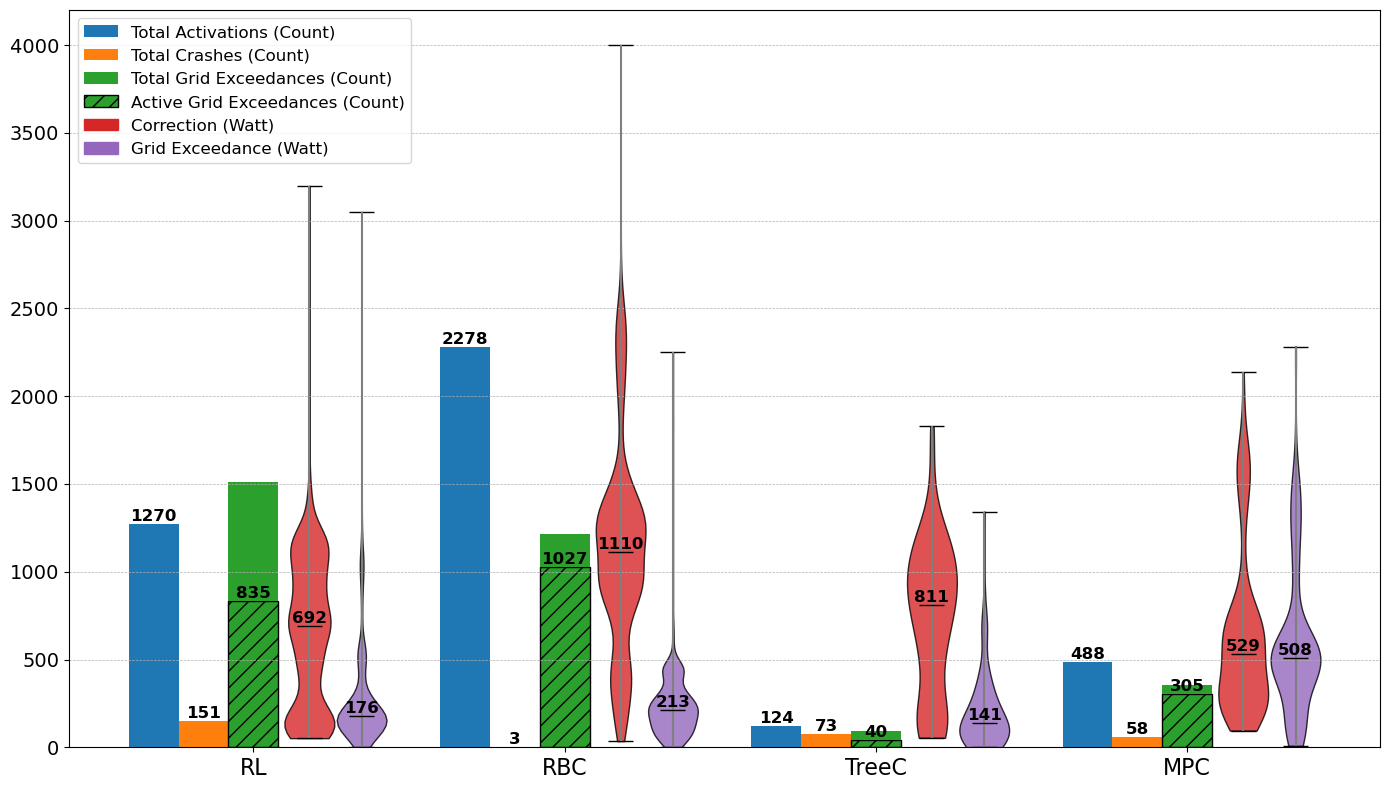

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches

# Filter out values below 9200 for grid data
for ems in ems_types:
    results['grid'][ems] = results['grid'][ems][results['grid'][ems] > 9200]

# Prepare the data for plotting
ems_labels = ems_types
total_activated_values = [results['activated'][ems] for ems in ems_types]
total_crashed_values = [int(results['crashed'][ems] * -1) for ems in ems_types]

# Data for the violin plots
correction_data = [results['correction'][ems].values * -1 for ems in ems_types]
grid_exchange_data = [results['grid'][ems].dropna().values - 9200 for ems in ems_types]

total_exceedance_values = [results['exceedances'][ems] for ems in ems_types]
total_active_exceedance_values = [results['active_exceedances'][ems] for ems in ems_types]

# Define the positions of the bars on the x-axis
x = np.arange(len(ems_labels)) * 1.25

# Set the width of the bars
width = 0.2

# Create the bar plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plotting the bars on the primary y-axis
bars1 = ax1.bar(x - 2*width, total_activated_values, width, label='Total Activations (Count)', color='tab:blue')
bars2 = ax1.bar(x - 1*width, total_crashed_values, width, label='Total Crashes (Count)', color='tab:orange')

# Plot the violin plots for correction data
violin_parts_correction = ax1.violinplot(correction_data, positions=x + 0.025 + 1*width, widths=width, showmeans=False, showmedians=True)

# Customizing the correction violin plots
for pc in violin_parts_correction['bodies']:
    pc.set_facecolor('tab:red')
    pc.set_edgecolor('black')
    pc.set_alpha(0.8)
# Set center line to grey
violin_parts_correction['cbars'].set_edgecolor('tab:gray')
for partname in ('cmins', 'cmaxes', 'cmedians'):
    vp = violin_parts_correction[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)

# Plot the violin plots for grid exchange data
violin_parts_grid = ax1.violinplot(grid_exchange_data, positions=x + 0.025 + 0.01 + 2*width, widths=width, showmeans=False, showmedians=True)

# Customizing the grid exchange violin plots
for pc in violin_parts_grid['bodies']:
    pc.set_facecolor('tab:purple')
    pc.set_edgecolor('black')
    pc.set_alpha(0.8)
# Set center line to grey
violin_parts_grid['cbars'].set_edgecolor('tab:gray')
for partname in ('cmins', 'cmaxes', 'cmedians'):
    vp = violin_parts_grid[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)

# Stacked bar for total and active exceedances
bars3a = ax1.bar(x, total_active_exceedance_values, width, label='Active Grid Exceedances (Count)', color='tab:green', hatch='//', edgecolor='black')
bars3b = ax1.bar(x, [total_exceedance_values[i] - total_active_exceedance_values[i] for i in range(len(ems_labels))], width, bottom=total_active_exceedance_values, label='Total Grid Exceedances (Count)', color='tab:green')

# Adding a custom legend for the violin plots
violin_patch_correction = mpatches.Patch(color='tab:red', label='Median Correction (Watt)')
violin_patch_grid = mpatches.Patch(color='tab:purple', label='Grid Exchange Power (Watt)')

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax1.set_xlabel('EMS Types', fontsize=16)
#ax1.set_title('Comparison of Safety Layer Results by EMS Type', fontsize=16)
ax1.set_xticks(x)
ax1.set_xticklabels(['RL', 'RBC', 'TreeC', 'MPC'], fontsize=16)
ax1.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Increase the size of the y-axis tick labels
ax1.tick_params(axis='y', labelsize=14)

# Combine legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = [violin_patch_correction, violin_patch_grid], ['Correction (Watt)', 'Grid Exceedance (Watt)']

# Reorder the legend to put "Inactive Grid Exceedances" before "Active Grid Exceedances"
handles1.insert(-1, handles1.pop(-1))
labels1.insert(-1, labels1.pop(-1))

ax1.legend(handles=handles1 + handles2, labels=labels1 + labels2, fontsize=12, loc='upper left')

# Attach a text label above each bar, displaying its height
def autolabel(bars, ax, offset=(0, 0)):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=offset,  # points offset
                    textcoords="offset points",
                    ha='center', va='bottom', color='black', fontsize=12, weight='bold')

# Extract and label the medians of the violin plots
def annotate_violins(violin_parts, ax, data, positions, offset=(0, 3)):
    """Annotate the medians of the violin plots."""
    for i, pos in enumerate(positions):
        median = np.median(data[i])
        ax.annotate('{}'.format(int(median)),
                    xy=(pos, median),
                    xytext=offset,  # points offset
                    textcoords="offset points",
                    ha='center', va='bottom', color='black', fontsize=12, weight='bold')

autolabel(bars1, ax1)
autolabel(bars2, ax1)
autolabel(bars3a, ax1, offset=(0, 0))
#autolabel(bars3b, ax1)

# Annotate the medians of the violin plots
annotate_violins(violin_parts_correction, ax1, correction_data, x + 0.025 + 1*width, offset=(0,0))
annotate_violins(violin_parts_grid, ax1, grid_exchange_data, x + 0.025 + 0.01 + 2*width, offset=(0,0))

fig.tight_layout()

plt.savefig('safetylayer_results_extend.pdf')
plt.show()


In [5]:
total_exceedance_values

[1513, 1213, 92, 354]

In [6]:
# RL grid exceedance in Wh
grid_exchange_data[0].sum() * 5/3600

593.9173611111111

In [7]:
# RBC grid exceedance in Wh
grid_exchange_data[1].sum() * 5/3600

408.3618055555556

In [8]:
# TreeC grid exceedance in Wh
grid_exchange_data[2].sum() * 5/3600

27.07777777777778

In [9]:
# TreeC grid exceedance in Wh
grid_exchange_data[3].sum() * 5/3600

295.47222222222223